# RAB phosphorylation screen for 3T3 cells

We analyze the screen data from the 
This notebook 
- runs guides couting
- does basic QC on guides counting
- run Mageck

CL, 2022-06-16

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sn
from scipy.stats import entropy

import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
%matplotlib inline

# Guide counting

In [ ]:
%bash

FQ_DIR="../data"
ANALYSIS_DIR="."
RESOURCES_DIR='../resources'
SCRIPTS_DIR='../scripts'

function _count_sgrna{
    python "${RESOURCES_DIR}/count_spacers_BRIE.py"  -f "${1}" -i "${RESOURCES_DIR}/broadgpp-brie-library.sequencesONLY.csv" -o "count_guides/${2}.counts.txt"
}

export _count_sgrna

cd $ANALYSIS_DIR

mkdir -p count_guides

ml system parallel

parallel -t -j8 '_count_sgrna {1} {2}' :::: <(cut -f1 samples_def.txt) ::::+ <(cut -f2 samples_def.txt)

parallel -t -j1 'echo {1}; cat count_guides/{1}.statistics.txt; echo -e "\n"' :::: <(cut -f2 samples_def.txt)

# Define libraries and load counts

In [ ]:
ANALYSIS_DIR = '.'
libs_df=pd.read_csv(os.path.join(ANALYSIS_DIR, 'samples_def.txt'), sep='\t', names=['file','name'], header=None, index_col=None, usecols=[0,1])
libs_df['sublib'] = 'brie'

In [8]:
libs={}
sublibs=list(set(libs_df.sublib))
for sublib in sublibs:
    libs[sublib]={k['name']: os.path.join(ANALYSIS_DIR,"count_guides",+k['name']+".counts.txt") for _, k in libs_df.loc[libs_df['sublib']==sublib].iterrows()}


In [9]:
libs['brie']

{'unsort_nig_2': 'count_guides/unsort_nig_2.counts.txt',
 'low_nig_2': 'count_guides/low_nig_2.counts.txt',
 'low_nig_1': 'count_guides/low_nig_1.counts.txt',
 'high_ctr_1': 'count_guides/high_ctr_1.counts.txt',
 'high_ctr_2': 'count_guides/high_ctr_2.counts.txt',
 'low_ctr_1': 'count_guides/low_ctr_1.counts.txt',
 'unsort_ctr_1': 'count_guides/unsort_ctr_1.counts.txt',
 'high_nig_1': 'count_guides/high_nig_1.counts.txt',
 'unsort_ctr_2': 'count_guides/unsort_ctr_2.counts.txt',
 'unsort_nig_1': 'count_guides/unsort_nig_1.counts.txt',
 'high_nig_2': 'count_guides/high_nig_2.counts.txt',
 'low_ctr_2': 'count_guides/low_ctr_2.counts.txt'}

In [11]:
libs_order = ['unsort_ctr_1', 'unsort_ctr_2', 'low_ctr_1', 'low_ctr_2','high_ctr_1','high_ctr_2',
              'unsort_nig_1', 'unsort_nig_2', 'low_nig_1', 'low_nig_2','high_nig_1','high_nig_2']

In [13]:
counts={}
for sublib in sublibs:
    counts[sublib]=pd.concat([pd.read_csv(libs[sublib][k], header=None, names=['seq','N'], index_col=0) for k in libs_order], keys=libs_order,axis=1, join='outer').xs('N', level=1, axis=1).fillna(0)

## Load guide->gene info

In [ ]:
guides={}
guides_file = {'brie':'/home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-FINAL.csv'}
for sublib in sublibs:
    guides[sublib]=pd.read_csv(guides_file[sublib], header=None, names=['seq','sgRNA','Gene'], sep='\t', index_col='seq', usecols=[0,1,2]) 
    guides[sublib]['GeneID']=guides[sublib]['Gene']

In [19]:
set(len(k) for k in guides['brie'].index.tolist())

{20}

# QC

In [14]:
sublibs_desc={'brie':"Brie"}

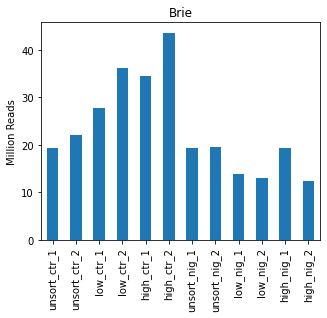

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
for i, s in enumerate(sublibs):
    
    hh=counts[s].sum(axis=0)/1000000
    ax=axs
    hh.plot.bar(ax=ax)
    ax.set_ylabel('Million Reads')
    ax.set_title(sublibs_desc[s])

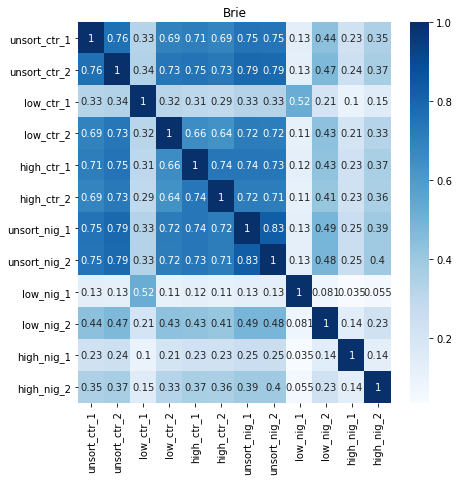

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
for i, s in enumerate(sublibs):
    ax=axs
    cr=counts[s].reindex(libs_order, axis=1).corr()
    sn.heatmap(cr, annot=True, cmap='Blues', ax=ax)
    ax.set_title(sublibs_desc[s])
#plt.show()

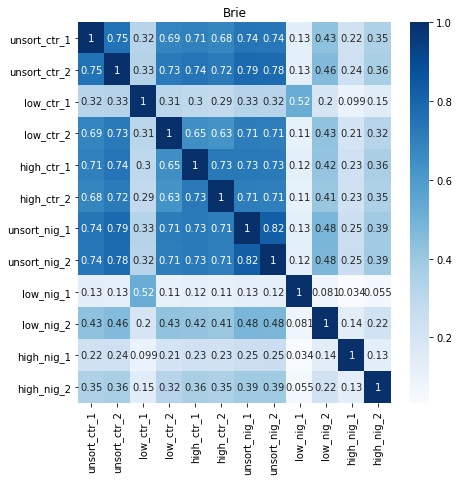

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
for i, s in enumerate(sublibs):
    ax=axs
    cr=counts[s].reindex(libs_order, axis=1)
    cr = cr.loc[cr.sum(axis=1)>100].corr()
    sn.heatmap(cr, annot=True, cmap='Blues', ax=ax)
    ax.set_title(sublibs_desc[s])
#plt.show()

In [21]:
counts['brie'].loc[counts['brie'].sum(axis=1)<100]

,unsort_ctr_1,unsort_ctr_2,low_ctr_1,low_ctr_2,high_ctr_1,high_ctr_2,unsort_nig_1,unsort_nig_2,low_nig_1,low_nig_2,high_nig_1,high_nig_2
seq,,,,,,,,,,,,
AACAAAACCAGAGTGATCTG,11,0,0,0,15,1,4,0,1,0,0,0
AACCTCGTCTCATGTACGAA,0,0,0,0,0,0,0,0,0,0,0,0
AATGAGCGTCTCTCGATCGC,0,0,0,0,0,25,10,14,1,1,0,0
ACACCGAGTAGCTCTCCTTG,12,5,2,3,56,1,7,9,0,1,0,0
ACATACCGGCAGAAACCCCG,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGTCTTCAGCGAAACTGG,7,9,0,1,27,0,0,1,0,0,1,0
TTCGAGACGGATACGTCTGC,0,0,0,56,1,0,0,12,0,0,0,0
TTCTTACCAGTGGTCCAGCG,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
for i, s in enumerate(sublibs):
    ax=axs
    cr=counts[s].reindex(libs_order, axis=1).corr()
    sn.heatmap(cr, annot=True, cmap='Blues', ax=ax)
    ax.set_title(sublibs_desc[s])
#plt.show()

# Add gene info

In [38]:
def annotate_count_table(df, guides, drop_unobserved=True):
    df_annotated=pd.concat([guides, df], axis=1, sort=False).fillna(0)
    if drop_unobserved:
        df_annotated.drop(df_annotated.loc[(df_annotated.iloc[:,2:].sum(axis=1)==0)].index, inplace=True)
        df_annotated=df_annotated.set_index(['sgRNA','Gene'])
    return df_annotated
    
def group_bygene(df_annotated):
    df_bygene=df_annotated.groupby('Gene').sum()
    return df_bygene

def scale_samples(df):
    x=df.values
#     x=np.maximum(1,x)
    scale=np.nanmedian(x/np.exp(np.nanmean(np.log(x), axis=1))[:,np.newaxis], axis=0)
    out=df/scale[np.newaxis,:]
    print(scale)
    return out

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    x = np.sort(array)
    n = array.shape[0]
    i = np.arange(1,n+1)
    
    
    return (np.sum((2*i-n-1) * np.sort(array)) / (n * np.sum(array))) #Gini coefficient

def get_entropy_stats(df):
    s=np.zeros((3,df.shape[1]))
    for i, c in enumerate(df.columns):
        s[0,i]=entropy(df[c])/np.log(len(df))
        s[1,i]=gini(df[c])
        s[2,i]=np.sum(df[c]==0)/len(df[c])*100
    out=pd.DataFrame(s, columns=df.columns, index=['entropy','gini','percent0'])
    return out
    

In [39]:
counts_annotated={k: annotate_count_table(v, guides[k]).drop('GeneID', axis=1) for k, v in counts.items()}

In [41]:
counts_annotated.keys()

dict_keys(['brie'])

In [42]:
!pwd
!mkdir -p mageck/all/brie

/oak/stanford/groups/astraigh/herschel/screen_jun2022


In [44]:
for k, cc in counts_annotated.items():
    cc.to_csv('./mageck/all/%s/counts_all.txt'%k, sep='\t', index=True)

In [45]:
df_stats={k: get_entropy_stats(df) for k, df in counts.items()}

In [46]:
df_stats

{'brie':           unsort_ctr_1  unsort_ctr_2  low_ctr_1  low_ctr_2  high_ctr_1  \
 entropy       0.986814      0.988055   0.971289   0.984878    0.987665   
 gini          0.298660      0.284156   0.422216   0.318473    0.289149   
 percent0      0.641694      0.534954   0.665553   0.644205    0.526164   
 
           high_ctr_2  unsort_nig_1  unsort_nig_2  low_nig_1  low_nig_2  \
 entropy     0.986769      0.986848      0.986742   0.856348   0.962417   
 gini        0.299376      0.296847      0.297997   0.823468   0.493854   
 percent0    0.522396      0.616579      0.606532   1.278364   1.177904   
 
           high_nig_1  high_nig_2  
 entropy     0.887838    0.945119  
 gini        0.775934    0.587566  
 percent0    0.976982    1.451659  }

In [47]:
def get_coverage_watershed(df, normalize=False, ax=None):
    s=np.zeros(df.shape)
    for i, c in enumerate(df.columns):
        x=-np.sort(-df[c])
        if normalize:
            x=x/np.median(x)
#         x=np.cumsum(x)
#         x=x/np.median(x)
        s[:,i]=x
    out=pd.DataFrame(s, columns=df.columns)
    if not ax is None:
        l=[]
        for x in out.columns:
            this_l=ax.plot(np.arange(1,len(out)+1)/len(out)*100,out[x], label=x)
            l+=[this_l]
        ax.set_yscale('log')
        ax.set_xlabel('Tag ID [%]')
        ax.set_ylabel('Representation')
        return out, l
    else:
        return out

def get_cumulative_coverage(df, ax=None):
    s=np.zeros(df.shape)
    for i, c in enumerate(df.columns):
        x=np.sort(df[c])
        x=x/np.median(x)
#         x=np.cumsum(x)
#         x=x/x[-1]
        
        s[:,i]=x
    out=pd.DataFrame(s, columns=df.columns)
    
    if not ax is None:
        l=[]
        for x in out.columns:
            this_l=ax.plot(out[x], np.arange(1,len(out)+1)/len(out)*100, label=x)
            l+=[this_l]
        ax.set_xscale('log')
        ax.set_xlabel('Normalized count')
        ax.set_ylabel('Cumulative Tag %') 
        return out, l
    
    else:
        return out

    
    

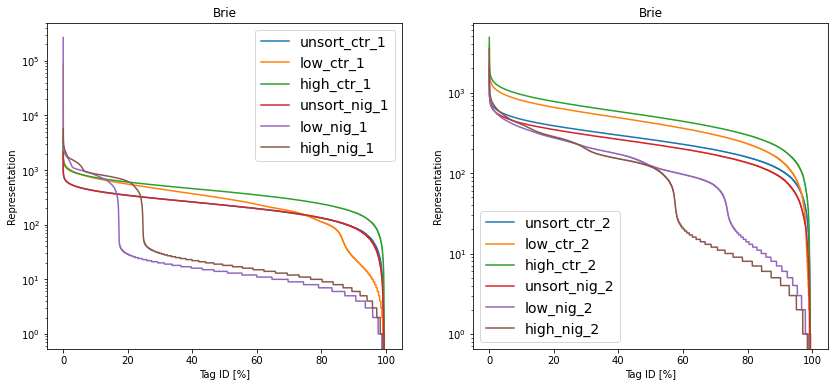

In [48]:
for s, df in counts.items():

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    df_rep1=df[[ x for x in df.columns if x.endswith('_1')]]
    df_rep2=df[[ x for x in df.columns if x.endswith('_2')]]

    out1, l1 = get_coverage_watershed(df_rep1, ax=axs[0])
    out2, l2 = get_coverage_watershed(df_rep2, ax=axs[1])
    for ax in axs:
        ax.legend()
        ax.set_title(sublibs_desc[s])

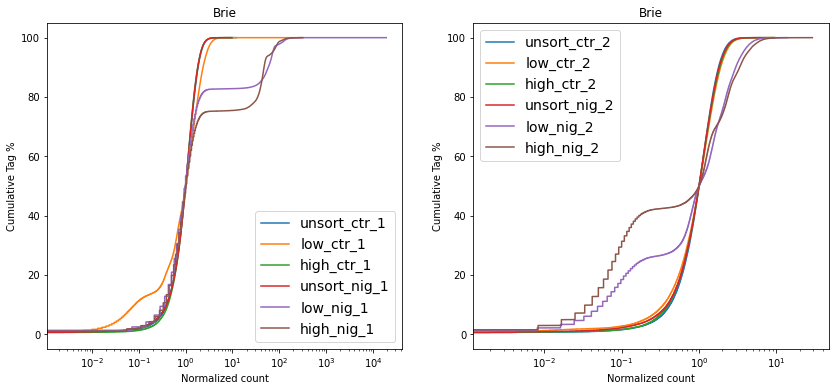

In [49]:
for s, df in counts.items():

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    df_rep1=df[[ x for x in df.columns if x.endswith('_1')]]
    df_rep2=df[[ x for x in df.columns if x.endswith('_2')]]

    out1, l1 = get_cumulative_coverage(df_rep1, ax=axs[0])
    out2, l2 = get_cumulative_coverage(df_rep2, ax=axs[1])
    for ax in axs:
        ax.legend()
        ax.set_title(sublibs_desc[s])

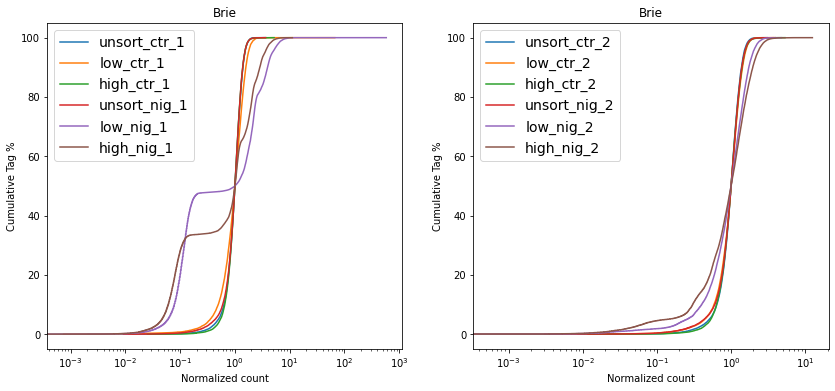

In [50]:
for s, df in counts.items():

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    df_rep1=df[[ x for x in df.columns if x.endswith('_1')]]
    df_rep2=df[[ x for x in df.columns if x.endswith('_2')]]

    out1, l1 = get_cumulative_coverage(group_bygene(annotate_count_table(df_rep1, guides[s])).drop('none', axis=0), ax=axs[0])
    out2, l2 = get_cumulative_coverage(group_bygene(annotate_count_table(df_rep2, guides[s])).drop('none', axis=0), ax=axs[1])
    for ax in axs:
        ax.legend()
        ax.set_title(sublibs_desc[s])

# Run MAGECK RRA

In [ ]:
parallel -j1 'mkdir -p {}/RRA' ::: brie
            
parallel -j8 -t 'mageck test -k {3}/counts_all.txt -t {1}_1,{1}_2 -c {2}_1,{2}_2 -n {3}/RRA/{1}_{2} --remove-zero both --remove-zero-threshold 10 --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --gene-lfc-method alphamedian' ::: high_nig  high_nig high_ctr high_ctr :::+ low_nig unsort_nig low_ctr unsort_ctr ::: brie
                                    
                                    

## Run MAGECK MLE

In [ ]:
conda activate $GROUP_HOME/miniconda3/envs/mageck

cd /oak/stanford/groups/astraigh/herschel/screen_jun2022/mageck/all

parallel -j1 'mkdir -p {}/MLE' ::: brie

parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: ctr nig
            


In [ ]:
parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: ctr_unsort nig_unsort ctr2 nig2 all

In [73]:
parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: ctr3 nig3

SyntaxError: invalid syntax (<ipython-input-73-51241ca51632>, line 1)

In [26]:
design_ctr_unsort = pd.DataFrame([["unsort_ctr_2","1","1"],
                                 ["high_ctr_1","1","2"],["high_ctr_2","1","2"],
                                 ["low_ctr_1","1","0"],["low_ctr_2","1","0"]], columns=["Samples", "baseline" ,"GFP"])
design_ctr_unsort.to_csv("./mageck/all/designmatrix_ctr3_noctr1.txt", sep='\t',index=False)

In [ ]:
parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: ctr3_noctr1

In [ ]:
parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: ctr3 nig3

In [55]:
os.getcwd()

'/oak/stanford/groups/astraigh/herschel/screen_jun2022'

In [83]:
design_ctr_unsort = pd.DataFrame([["unsort_ctr_1","1","0"],["unsort_ctr_2","1","0"],
                                 ["unsort_nig_1","1","1"],["unsort_nig_2","1","1"]], columns=["Samples", "baseline" ,"NIG"])
design_ctr_unsort.to_csv("./mageck/all/designmatrix_ctr_unsort.txt", sep='\t',index=False)


design_ctr_unsort.to_csv("./mageck/all/designmatrix_nigONLY.txt", sep='\t',index=False)

In [66]:
design_ctr_unsort = pd.DataFrame([["unsort_ctr_1","1","0"],["unsort_ctr_2","1","0"],
                                 ["high_ctr_1","1","1"],["high_ctr_2","1","1"]], columns=["Samples", "baseline" ,"GFP"])
design_ctr_unsort.to_csv("./mageck/all/designmatrix_ctr_unsort.txt", sep='\t',index=False)

design_nig_unsort = pd.DataFrame([["unsort_nig_1","1","0"],["unsort_nig_2","1","0"],
                                 ["high_nig_1","1","1"],["high_nig_2","1","1"]], columns=["Samples", "baseline" ,"GFP"])
design_nig_unsort.to_csv("./mageck/all/designmatrix_nig_unsort.txt", sep='\t',index=False)

In [67]:
design_ctr_unsort = pd.DataFrame([["unsort_ctr_1","1","0"],["unsort_ctr_2","1","0"],
                                 ["high_ctr_1","1","1"],["high_ctr_2","1","1"],
                                 ["low_ctr_1","1","-1"],["low_ctr_2","1","-1"]], columns=["Samples", "baseline" ,"GFP"])
design_ctr_unsort.to_csv("./mageck/all/designmatrix_ctr2.txt", sep='\t',index=False)

design_nig_unsort = pd.DataFrame([["unsort_nig_1","1","0"],["unsort_nig_2","1","0"],
                                 ["high_nig_1","1","1"],["high_nig_2","1","1"],
                                 ["low_nig_1","1","-1"],["low_nig_2","1","-1"]], columns=["Samples", "baseline" ,"GFP"])
design_nig_unsort.to_csv("./mageck/all/designmatrix_nig2.txt", sep='\t',index=False)


In [72]:
design_ctr_unsort = pd.DataFrame([["unsort_ctr_1","1","1"],["unsort_ctr_2","1","1"],
                                 ["high_ctr_1","1","2"],["high_ctr_2","1","2"],
                                 ["low_ctr_1","1","0"],["low_ctr_2","1","0"]], columns=["Samples", "baseline" ,"GFP"])
design_ctr_unsort.to_csv("./mageck/all/designmatrix_ctr3.txt", sep='\t',index=False)

design_nig_unsort = pd.DataFrame([["unsort_nig_1","1","1"],["unsort_nig_2","1","1"],
                                 ["high_nig_1","1","2"],["high_nig_2","1","2"],
                                 ["low_nig_1","1","0"],["low_nig_2","1","0"]], columns=["Samples", "baseline" ,"GFP"])
design_nig_unsort.to_csv("./mageck/all/designmatrix_nig3.txt", sep='\t',index=False)

In [62]:
! cat ./mageck/all/designmatrix_ctr2.csv 

Samples	baseline	GFP
unsort_ctr_1	1	0
unsort_ctr_2	1	0
high_ctr_1	1	1
high_ctr_2	1	1
low_ctr_1	1	-1
low_ctr_2	1	-1


In [68]:
design_all = pd.DataFrame([["unsort_ctr_1","1","0","0","0"],["unsort_ctr_2","1","0","0","0"],
                                 ["high_ctr_1","1","1","0","0"],["high_ctr_2","1","1","0","0"],
                                 ["low_ctr_1","1","-1","0","0"],["low_ctr_2","1","-1","0","0"],
                          ["unsort_nig_1","1","0","1","0"],["unsort_nig_2","1","0","1","0"],
                                 ["high_nig_1","1","1","1","1"],["high_nig_2","1","1","1","1"],
                                 ["low_nig_1","1","-1","1","-1"],["low_nig_2","1","-1","1","-1"]], columns=["Samples", "baseline" ,"GFP","NIG","GFPiNIG"])
design_all.to_csv("./mageck/all/designmatrix_all.txt", sep='\t',index=False)


In [82]:
design_all = pd.DataFrame([["unsort_ctr_1","1","1","0"],["unsort_ctr_2","1","1","0"],
                                 ["high_ctr_1","1","2","0"],["high_ctr_2","1","2","0"],
                                 ["low_ctr_1","1","0","0"],["low_ctr_2","1","0","0"],
                          ["unsort_nig_1","1","1","1"],["unsort_nig_2","1","1","1"],
                                 ["high_nig_1","1","2","1"],["high_nig_2","1","2","1"],
                                 ["low_nig_1","1","0","1"],["low_nig_2","1","0","1",]], columns=["Samples", "baseline" ,"GFP","NIG"])
design_all.to_csv("./mageck/all/designmatrix_all3.txt", sep='\t',index=False)

In [80]:
! cat ./mageck/all/designmatrix_all3.txt

Samples	baseline	GFP	NIG	GFPiNIG
unsort_ctr_1	1	1	0	0
unsort_ctr_2	1	1	0	0
high_ctr_1	1	2	0	0
high_ctr_2	1	2	0	0
low_ctr_1	1	0	0	0
low_ctr_2	1	0	0	0
unsort_nig_1	1	1	1	0
unsort_nig_2	1	1	1	0
high_nig_1	1	2	1	1
high_nig_2	1	2	1	1
low_nig_1	1	0	1	-1
low_nig_2	1	0	1	-1


In [65]:
! cat ./mageck/all/designmatrix_all.csv 

Samples	baseline	GFP	NIG	GFPiNIG
unsort_ctr_1	1	0	0	0
unsort_ctr_2	1	0	0	0
high_ctr_1	1	1	0	0
high_ctr_2	1	1	0	0
low_ctr_1	1	-1	0	0
low_ctr_2	1	-1	0	0
unsort_nig_1	1	0	1	0
unsort_nig_2	1	0	1	0
high_nig_1	1	1	1	1
high_nig_2	1	1	1	1
low_nig_1	1	-1	1	-1
low_nig_2	1	-1	1	-1


In [69]:
design_all = pd.DataFrame([
                                 ["high_ctr_1","1","1","0","0"],["high_ctr_2","1","1","0","0"],
                                 ["low_ctr_1","1","0","0","0"],["low_ctr_2","1","0","0","0"],
                                 ["high_nig_1","1","1","1","1"],["high_nig_2","1","1","1","1"],
                                 ["low_nig_1","1","0","1","0"],["low_nig_2","1","0","1","0"]], columns=["Samples", "baseline" ,"GFP","NIG","GFPiNIG"])
design_all.to_csv("./mageck/all/designmatrix_all_extremes.txt", sep='\t',index=False)

In [70]:
! cat ./mageck/all/designmatrix_all_extremes.txt 

Samples	baseline	GFP	NIG	GFPiNIG
high_ctr_1	1	1	0	0
high_ctr_2	1	1	0	0
low_ctr_1	1	0	0	0
low_ctr_2	1	0	0	0
high_nig_1	1	1	1	1
high_nig_2	1	1	1	1
low_nig_1	1	0	1	0
low_nig_2	1	0	1	0


In [ ]:
parallel -t --ungroup -j1 'mageck mle --threads 8 --count-table brie/counts_all.txt --design-matrix designmatrix_{1}.txt --norm-method control --control-sgrna /home/groups/astraigh/people/charles/projects/herschel/resources/broadgpp-brie-library-NONTARGETTING.csv --output-prefix brie/MLE/{1}' ::: all_extremes